# CAPSTONE

To create a recommender model to assist the Sales & Marketing Department in identifying cross-selling opportunities to our customers through identifying customer segments by applying clustering techniques on customer sales data, including natural language processing of product descriptions to identify product categories.

Deliverables: to deliver a recommender model that improves by at least 10% accuracy from baseline model without feature engineering.

Customer Segementation by 
- RFM: (Recency, Frequency, Monetary) using K-means/DBScan/Hierarchical clustering
https://www.optimove.com/resources/learning-center/customer-segmentation-via-cluster-analysis#:~:text=In%20the%20context%20of%20customer,archetypes%E2%80%9D%20or%20%E2%80%9Cpersonas%E2%80%9D.

https://www.analyticsvidhya.com/blog/2020/10/quick-guide-to-evaluation-metrics-for-supervised-and-unsupervised-machine-learning/

https://www.shopify.com.sg/encyclopedia/customer-segmentation#:~:text=Customer%20segmentation%20is%20the%20process,Number%20of%20employees


https://analyticsindiamag.com/how-to-measure-the-success-of-a-recommendation-system/

https://www.kaggle.com/code/azizozmen/customer-segmentation-cohort-rfm-analysis-k-means

https://www.kaggle.com/code/ozlemilgun/customer-segmentation-using-rfm-analysis

https://www.kaggle.com/code/mathchi/business-problem-with-customer-segmentation

- Product segmentation (categorical) using K modes, Jacard Distance
Categorize products into main categories by performing NLP on product description (parts of speech tagging)

https://www.analyticsvidhya.com/blog/2021/06/kmodes-clustering-algorithm-for-categorical-data/#:~:text=KModes%20clustering%20is%20one%20of,similar%20our%20data%20points%20are.

- Clustering of combination of categorical and numerical features (Gower Distance, Dimensionality Reduction Techniques, K-prototypes)

Dataset only has 8 columns. Segmentation would require feature engineering to identify additional features for clustering. 

Unique product descriptions are about 4000+, which detail product type and variants like colour, design, and number of items it contains.

We would use RFM (Recency, Frequency, Monetary) Analysis to numerical sales data 

8 feature columns, 540K observations
'InvoiceNo' - 25900 unique
'stockcode_caps' - 4070 unique
'description_new' - 4223 unique, includes adjustment entries like stock returns, discounts 
'Quantity'
'InvoiceDate' - 1 year period
'UnitPrice'
'CustomerID' - 4372 unique
'Country' - 38 countries, 91% from one country

Assume average gross margin is 42%, net margin is 7% - online retail
https://pages.stern.nyu.edu/~adamodar/New_Home_Page/datafile/margin.html

https://en.wikipedia.org/wiki/List_of_countries_by_United_Nations_geoscheme

1. What is your problem statement?  What will you actually be doing?

2. Who is your audience?  Why will they care?
 
3. What is your success metric?  How will you know if you are actually solving the problem in a useful way?

4. What is your data source?  What format is your data in?  How much cleaning and munging will be required?

5. What are potential challenges or obstacles and how will you mitigate them?

6. Is this a reasonable project given the time constraints that you have?



Week starting 25 Apr
First half
- Import and clean data
- NLP of product categories
- EDA on product categories
- Product category clustering - K modes
- Create basic recommender model, error analysis, tuning

Second half
- Feature engineering for sales data - RFM analysis
- RFM clustering (K-means)
- Add to recommender model, error analysis, tuning

Week starting 2 May
First half
- Clustering with combined categorical variables and numerical variables
- Add other clustering methods DBScan/ Hierarchical clustering/Gower Distance/ Dimensionality Reduction Techniques/ K-prototypes
- Error analysis, tuning

Second half
Prepare presentation slides
Stretch goal - Impute COGS based on industry assumptions to add dimension to the business proposal

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import TruncatedSVD



In [2]:
# Set chart style
plt.style.use('Solarize_Light2')

In [3]:
# Import data
sales = pd.read_csv('../data/cleaned_sales.csv', 
                         dtype={'invoiceno': 'object', 
                                 'stockcode_caps': 'object', 
                                 'quantity': np.int32, 
                                 'unitprice': np.float32, 
                                 'customerid': 'object'
                                })

In [4]:
customer_location = pd.read_csv('../data/cleaned_customer.csv')
stock_descriptions= pd.read_csv('../data/cleaned_stock_descriptions.csv')
invoice = pd.read_csv('../data/cleaned_invoice.csv')

In [5]:
# Check column types and null values
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536493 entries, 0 to 536492
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   invoiceno       536493 non-null  object 
 1   stockcode_caps  536493 non-null  object 
 2   quantity        536493 non-null  int32  
 3   unitprice       536493 non-null  float32
 4   customerid      536493 non-null  object 
dtypes: float32(1), int32(1), object(3)
memory usage: 16.4+ MB


In [6]:
# Check column types and null values
customer_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerid  5772 non-null   object
 1   domestic    5772 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 50.9+ KB


In [7]:
# Check column types and null values
stock_descriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   stockcode_caps   3817 non-null   object
 1   description_new  3817 non-null   object
dtypes: object(2)
memory usage: 59.8+ KB


In [8]:
# Check column types and null values
invoice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23195 entries, 0 to 23194
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   invoiceno    23195 non-null  object
 1   invoicedate  23195 non-null  object
 2   test         23195 non-null  bool  
dtypes: bool(1), object(2)
memory usage: 385.2+ KB


In [9]:
# convert time to datetime
invoice['invoicedate'] = pd.to_datetime(invoice['invoicedate'])

In [12]:
# Join datasets together
sales_data = sales.merge(customer_location, on='customerid') \
            .merge(invoice, on='invoiceno')

In [13]:
# Calculate revenue from unit price and quantity
sales_data['revenue'] = sales_data['unitprice'] * sales_data['quantity'] 

### Analysis of Sales by Customer

In [14]:
latest_date = sales_data['invoicedate'].max()

In [15]:
sales_by_cust = sales_data.groupby('customerid').agg(total_revenue=('revenue',np.sum),
                                                total_qty=('quantity',np.sum),
                                                num_invoices=('invoiceno',lambda x: x.nunique()),
                                                unique_products=('stockcode_caps',lambda x: x.nunique()),
                                                recency=('invoicedate',
                                                         lambda x: (latest_date - x.max()).days)
                                               ).reset_index()

In [16]:
sales_by_cust = sales_by_cust[sales_by_cust['total_revenue']>0]

In [17]:
sales_by_cust.sort_values(by='total_revenue',ascending=False)

customerid  total_revenue  total_qty  num_invoices  unique_products  \
1699      14646  278778.019436     196556            73              699   
4223      18102  259657.298465      64124            60              150   
3749      17450  189735.530978      69041            49              124   
1891      14911  128882.129288      76848           242             1791   
55        12415  123638.180134      76946            24              443   
...         ...            ...        ...           ...              ...   
4770     546876       0.840000          2             1                2   
4601     542136       0.840000          2             1                1   
5275     560217       0.790000          1             1                1   
4544     540833       0.650000          1             1                1   
4456     539441       0.420000          1             1                1   

      recency  
1699        1  
4223        0  
3749        7  
1891        0  
55         23  
...       ...  
4770      266  
4601      317  
5275      146  
4544      331  
4456      356  

[5691 rows x 6 columns]

Text(0.5, 1.02, 'Customer RFM distribution')

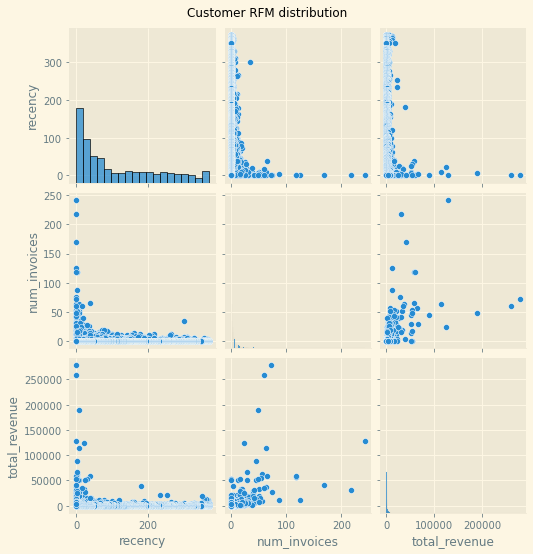

In [18]:
g = sns.pairplot(data=sales_by_cust[['recency','num_invoices','total_revenue']])
g.fig.suptitle("Customer RFM distribution", y=1.02)

In [19]:
sales_by_cust['custsales_quntiles'] = pd.qcut(sales_by_cust.total_revenue, 5, labels = [5,4,3,2,1])

In [20]:
sales_by_cust.groupby(pd.qcut(sales_by_cust['total_revenue'], 5, labels = [5,4,3,2,1])) \
                [['total_revenue','total_qty','num_invoices']].sum().transform(lambda x: x / x.sum()) \
                .rename_axis('Customer by Total Sales Quintile')

total_revenue  total_qty  num_invoices
Customer by Total Sales Quintile                                        
5                                      0.008645   0.009814      0.055604
4                                      0.034016   0.037259      0.077126
3                                      0.071225   0.075656      0.125498
2                                      0.153529   0.152606      0.193617
1                                      0.732585   0.724664      0.548155

RFM scores

In [21]:
sales_by_cust.recency

1         1
2        74
3        18
4       309
5        35
       ... 
5728      0
5729      0
5730      0
5731      0
5732      0
Name: recency, Length: 5691, dtype: int64

In [22]:
sales_by_cust['recency_score'] = pd.qcut(sales_by_cust.recency.rank(method='first'), 
                                         3, 
                                         labels = ['3','2','1'])

In [23]:
sales_by_cust['frequency_score'] = pd.qcut(sales_by_cust.num_invoices.rank(method='first'), 
                                           3, 
                                           labels = ['1','2','3'])

In [24]:
sales_by_cust['monetary_score'] = pd.qcut(sales_by_cust.total_revenue.rank(method='first'), 
                                          3, 
                                          labels = ['1','2','3'])

In [25]:
sales_by_cust['RFM_group'] = sales_by_cust[['recency_score',
                                            'frequency_score',
                                            'monetary_score']].agg(''.join, axis=1)

In [26]:
sales_by_cust.groupby('RFM_group').agg(cust_count=('customerid',np.size),
                                        total_revenue=('total_revenue',np.sum),
                                        avg_recency=('recency',np.mean),
                                        avg_invoices=('num_invoices',np.mean),
                                        avg_revenue=('total_revenue',np.mean),
                                               ).reset_index().sort_values(by='total_revenue',
                                                                           ascending=False)

RFM_group  cust_count  total_revenue  avg_recency  avg_invoices  \
26       333         885   5.526334e+06    10.743503     13.810169   
17       233         340   9.480187e+05    65.894118      7.141176   
14       223         239   5.320898e+05    83.251046      1.539749   
2        113         174   4.779997e+05   299.114943      1.000000   
23       323         112   4.387151e+05    13.571429      1.723214   
25       332         298   2.340336e+05    13.724832      4.869128   
13       222         316   2.051307e+05    80.740506      2.170886   
5        123          91   1.839196e+05   195.912088      1.351648   
1        112         302   1.710824e+05   273.629139      1.000000   
16       232         219   1.600864e+05    70.630137      4.502283   
22       322         224   1.427893e+05    14.924107      2.294643   
8        133          30   1.377341e+05   214.366667      7.933333   
4        122         227   1.323575e+05   214.563877      1.814978   
10       212         182   9.815213e+04    72.829670      1.000000   
0        111         714   8.881773e+04   283.277311      1.000000   
9        211         290   5.462988e+04    76.120690      1.000000   
11       213          22   5.061078e+04    88.227273      1.000000   
7        132          64   4.445404e+04   208.375000      4.625000   
3        121         274   4.073294e+04   205.759124      1.503650   
12       221         266   3.199821e+04    83.612782      1.447368   
19       312          65   3.190610e+04    17.461538      1.000000   
18       311         144   2.594690e+04    17.506944      1.000000   
21       321         148   2.251922e+04    14.520270      1.662162   
20       313           4   8.284760e+03    15.000000      1.000000   
6        131          21   5.005480e+03   228.285714      3.904762   
15       231          23   4.663560e+03    90.521739      3.739130   
24       331          17   3.863630e+03     9.352941      3.941176   

    avg_revenue  
26  6244.444757  
17  2788.290220  
14  2226.317277  
2   2747.124593  
23  3917.099011  
25   785.347646  
13   649.147845  
5   2021.095053  
1    566.498046  
16   730.988351  
22   637.452094  
8   4591.135654  
4    583.072598  
10   539.297415  
0    124.394579  
9    188.378895  
11  2300.489991  
7    694.594372  
3    148.660365  
12   120.294022  
19   490.863074  
18   180.186804  
21   152.156891  
20  2071.189995  
6    238.356189  
15   202.763479  
24   227.272352

In [27]:
# Join customer quintile ranking to sales_data table
sales_data = sales_data.merge(sales_by_cust[['customerid','custsales_quntiles']], 
                              how='left', 
                              on='customerid')

In [28]:
sales_data.head()

invoiceno stockcode_caps  quantity  unitprice customerid  domestic  \
0    536365         85123A         6       2.55      17850      True   
1    536365          71053         6       3.39      17850      True   
2    536365         84406B         8       2.75      17850      True   
3    536365         84029G         6       3.39      17850      True   
4    536365         84029E         6       3.39      17850      True   

          invoicedate   test    revenue custsales_quntiles  
0 2010-12-01 08:26:00  False  15.300000                  1  
1 2010-12-01 08:26:00  False  20.340001                  1  
2 2010-12-01 08:26:00  False  22.000000                  1  
3 2010-12-01 08:26:00  False  20.340001                  1  
4 2010-12-01 08:26:00  False  20.340001                  1

In [29]:
sales_data.groupby('custsales_quntiles').agg(total_revenue=('revenue',np.sum),
                                                total_qty=('quantity',np.sum),
                                                num_invoices=('invoiceno',lambda x: x.nunique()),
                                                 unique_products=('stockcode_caps',lambda x: x.nunique()),
                                                cust_count=('customerid',lambda x: x.nunique())
                                               )

total_revenue  total_qty  num_invoices  unique_products  \
custsales_quntiles                                                            
5                    8.473964e+04      52106          1284             2498   
4                    3.334245e+05     197824          1781             3018   
3                    6.981368e+05     401691          2898             3208   
2                    1.504868e+06     810252          4471             3503   
1                    7.180707e+06    3847548         12658             3698   

                    cust_count  
custsales_quntiles              
5                         1139  
4                         1138  
3                         1138  
2                         1138  
1                         1138

In [30]:
sales_data['revenue'].sum()

9793394.643943742

<AxesSubplot:xlabel='num_invoices', ylabel='unique_products'>

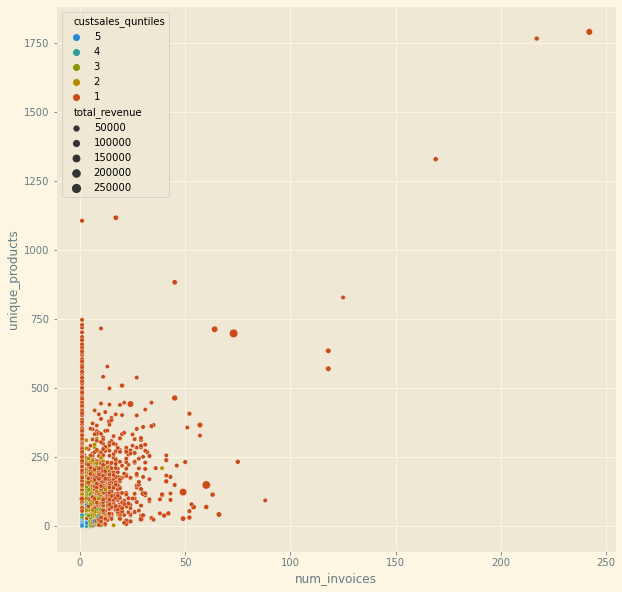

In [32]:
fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=sales_by_cust[sales_by_cust['total_revenue']>0], 
                x='num_invoices', 
                y='unique_products', 
                size='total_revenue', 
                hue='custsales_quntiles')

In [33]:
sales_by_cust.head()

customerid  total_revenue  total_qty  num_invoices  unique_products  \
1      12347    4309.999988       2458             7              103   
2      12348    1437.239997       2332             4               21   
3      12349    1457.549994        630             1               72   
4      12350     294.399997        196             1               16   
5      12352    1265.409991        463             8               57   

   recency custsales_quntiles recency_score frequency_score monetary_score  \
1        1                  1             3               3              3   
2       74                  2             2               3              3   
3       18                  2             3               1              3   
4      309                  4             1               1              1   
5       35                  2             2               3              3   

  RFM_group  
1       333  
2       233  
3       313  
4       111  
5       233

In [34]:
sales_by_cust.sum()

C:\Users\deang\AppData\Local\Temp\ipykernel_19728\2866679969.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  sales_by_cust.sum()


customerid         1234712348123491235012352123531235412355123561...
total_revenue                                         9801875.883915
total_qty                                                    5309421
num_invoices                                                   23092
unique_products                                               397555
recency                                                       653777
RFM_group          3332333131112331111121123232133223332231113332...
dtype: object

[Text(0.5, 1.0, 'Distribution of sales by customers'),
 Text(0.5, 0, 'Index of Customers'),
 Text(0, 0.5, 'total_sales')]

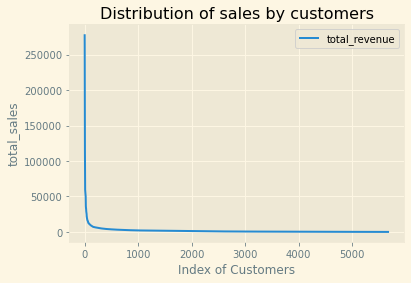

In [35]:
sns.lineplot(data=sales_by_cust[['total_revenue']].
             sort_values('total_revenue',
                         ascending=False,
                         ignore_index=True),
             ).set(title='Distribution of sales by customers', 
                   xlabel='Index of Customers', 
                   ylabel='total_sales')

[Text(0.5, 1.0, 'Distribution of purchases by customers'),
 Text(0.5, 0, 'Index of Customers'),
 Text(0, 0.5, 'Number of invoices')]

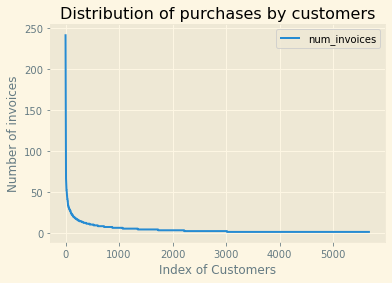

In [36]:
sns.lineplot(data=sales_by_cust[['num_invoices']].
             sort_values('num_invoices',
                         ascending=False,
                         ignore_index=True),
             ).set(title='Distribution of purchases by customers', 
                   xlabel='Index of Customers', 
                   ylabel='Number of invoices')

Sales per product

In [37]:
sales_by_product = sales_data.groupby('stockcode_caps').agg(total_revenue=('revenue',np.sum),
                                                total_qty=('quantity',np.sum),
                                                num_invoices=('invoiceno',lambda x: x.nunique()),
                                                 unique_customers=('customerid',lambda x: x.nunique())
                                               ).reset_index()

In [38]:
sales_by_product['avg_product_purchase'] = sales_by_product['total_revenue'] / sales_by_product['num_invoices']

In [39]:
sales_by_product[sales_by_product['total_revenue']<0]

stockcode_caps  total_revenue  total_qty  num_invoices  unique_customers  \
157           20703     -25.500000         -6             4                 3   
275           20957      -1.450000         -1             1                 1   
567           21412      -2.520000         -6             1                 1   
704           21645     -39.599999        -24             1                 1   
956           22034      -0.020000         -2             5                 5   
2475          35400     -45.699999         -6            13                13   
2517          35832      -2.950000         -1             1                 1   
2597          37503     -10.750000         -1             1                 1   
2820          79320      -4.950000         -1             1                 1   
2823         79323P     -27.000000         -4             3                 1   
2824         79323W     -54.000000         -8             1                 1   
3058         84750A      -5.850000         -3             3                 2   
3107          84839      -5.550000         -1             1                 1   
3235         85023C      -2.550000         -1             1                 1   
3267          85042     -14.849999         -3             2                 2   
3285          85063     -46.850000         -3             2                 2   
3287          85065     -12.750000         -1             1                 1   
3290          85068      -7.950000         -1             1                 1   
3306         85098B      -3.750000         -1             1                 1   

      avg_product_purchase  
157              -6.375000  
275              -1.450000  
567              -2.520000  
704             -39.599999  
956              -0.004000  
2475             -3.515385  
2517             -2.950000  
2597            -10.750000  
2820             -4.950000  
2823             -9.000000  
2824            -54.000000  
3058             -1.950000  
3107             -5.550000  
3235             -2.550000  
3267             -7.425000  
3285            -23.425000  
3287            -12.750000  
3290             -7.950000  
3306             -3.750000

In [40]:
sales_by_product = sales_by_product[sales_by_product['total_revenue']>0]

In [41]:
sales_by_product['prodsales_quntiles'] = pd.qcut(sales_by_product.total_revenue, 5, labels = [5,4,3,2,1])

In [42]:
sales_by_product.groupby(pd.qcut(sales_by_product['total_revenue'], 5, labels = [5,4,3,2,1])) \
                [['total_revenue','total_qty','num_invoices']].sum().transform(lambda x: x / x.sum()) \
                .rename_axis('Products by Total Sales Quintile')

total_revenue  total_qty  num_invoices
Products by Total Sales Quintile                                        
5                                      0.002536   0.004019      0.010481
4                                      0.017819   0.037442      0.047623
3                                      0.056420   0.098839      0.118582
2                                      0.144793   0.214646      0.226208
1                                      0.778432   0.645054      0.597105

In [43]:
# Join product quintile ranking to sales_data table
sales_data = sales_data.merge(sales_by_product[['stockcode_caps','prodsales_quntiles']], 
                              how='left', 
                              on='stockcode_caps')

In [44]:
sales_data.groupby('prodsales_quntiles').agg(total_revenue=('revenue',np.sum),
                                                total_qty=('quantity',np.sum),
                                                num_invoices=('invoiceno',lambda x: x.nunique()),
                                                 unique_products=('stockcode_caps',lambda x: x.nunique()),
                                                cust_count=('customerid',lambda x: x.nunique())
                                               )

total_revenue  total_qty  num_invoices  unique_products  \
prodsales_quntiles                                                            
5                    2.483695e+04      21321          2167              759   
4                    1.745134e+05     198637          6587              759   
3                    5.525630e+05     524356         11714              758   
2                    1.418059e+06    1138735         16327              759   
1                    7.623737e+06    3422128         21772              759   

                    cust_count  
prodsales_quntiles              
5                         1417  
4                         3164  
3                         4380  
2                         5106  
1                         5556

<AxesSubplot:xlabel='unique_customers', ylabel='avg_product_purchase'>

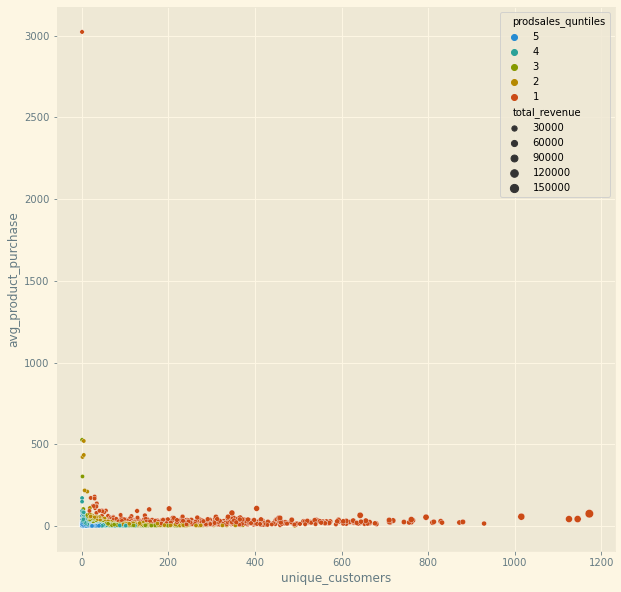

In [45]:
fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=sales_by_product, 
                x='unique_customers', 
                y='avg_product_purchase', 
                size='total_revenue', 
                hue='prodsales_quntiles')

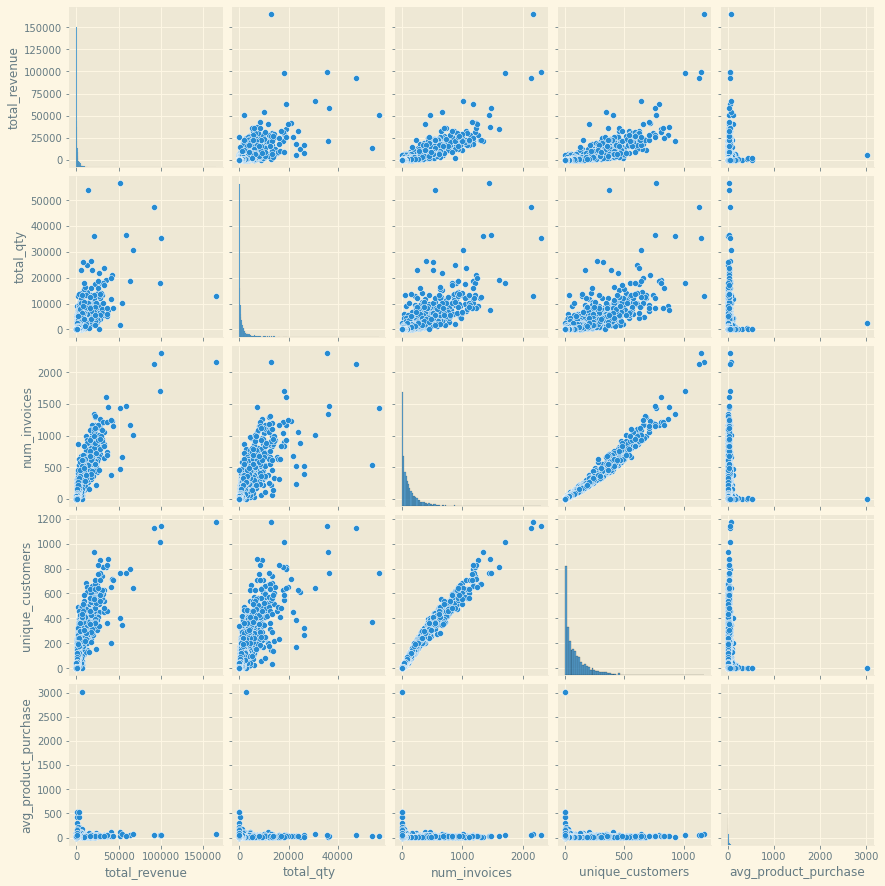

In [46]:
sns.pairplot(data=sales_by_product)

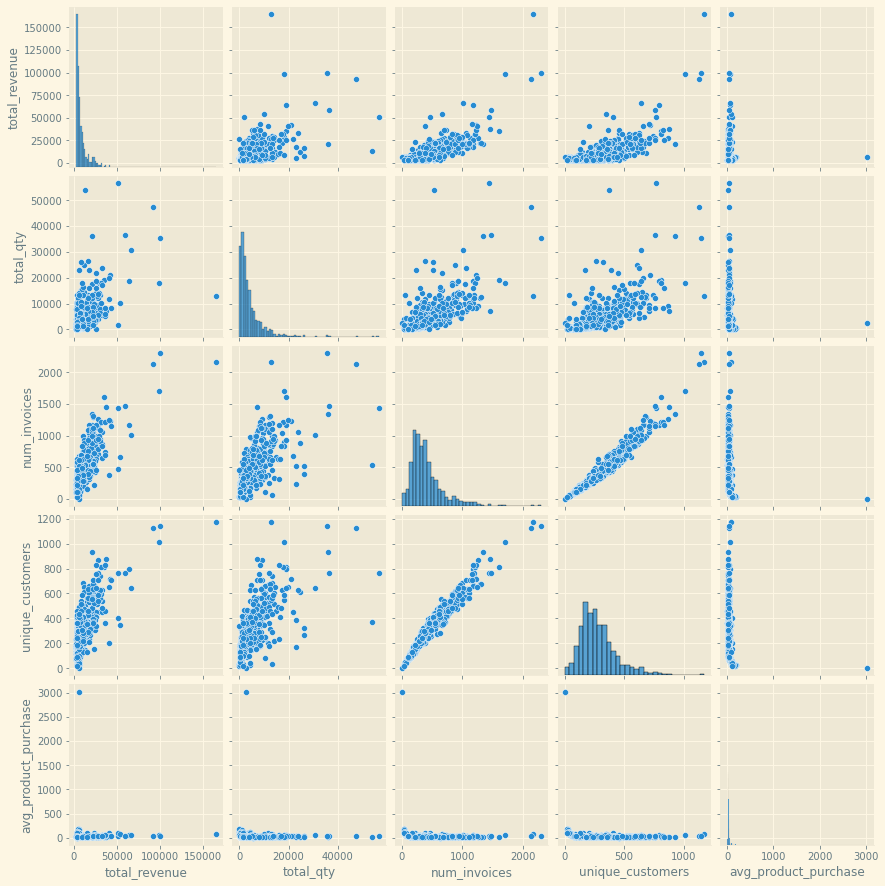

In [47]:
sns.pairplot(data=sales_by_product[sales_by_product['prodsales_quntiles']==1])

In [48]:
sales_by_product[['unique_customers']]. \
             sort_values('unique_customers',ascending=False,ignore_index=True)

unique_customers
0                 1172
1                 1145
2                 1125
3                 1015
4                  929
...                ...
3789                 1
3790                 1
3791                 1
3792                 1
3793                 1

[3794 rows x 1 columns]

[Text(0.5, 1.0, 'Distribution of number of customers by product'),
 Text(0.5, 0, 'Index of Products'),
 Text(0, 0.5, 'Unique Customers')]

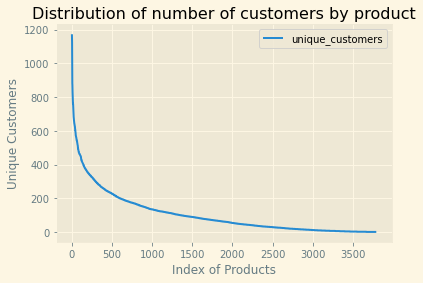

In [49]:
sns.lineplot(data=sales_by_product[['unique_customers']].
             sort_values('unique_customers',
                         ascending=False,
                         ignore_index=True),
             ).set(title='Distribution of number of customers by product', 
                   xlabel='Index of Products', 
                   ylabel='Unique Customers')

In [50]:
sales_by_product.sort_values(by='total_revenue', ascending=False)

stockcode_caps  total_revenue  total_qty  num_invoices  unique_customers  \
1308          22423  164762.187790      13022          2168              1172   
3323         85123A   99846.979964      35374          2307              1145   
2663          47566   98302.979317      18018          1705              1015   
3307         85099B   92356.028571      47359          2132              1125   
1940          23084   66756.588769      30680          1009               643   
...             ...            ...        ...           ...               ...   
2885         84201C       0.950000          5             1                 1   
3573          90084       0.850000          1             1                 1   
472           21268       0.840000          2             1                 1   
3269          85047       0.800000          0             4                 4   
2892          84227       0.420000          1             1                 1   

      avg_product_purchase prodsales_quntiles  
1308             75.997319                  1  
3323             43.280009                  1  
2663             57.655706                  1  
3307             43.318963                  1  
1940             66.161139                  1  
...                    ...                ...  
2885              0.950000                  5  
3573              0.850000                  5  
472               0.840000                  5  
3269              0.200000                  5  
2892              0.420000                  5  

[3794 rows x 7 columns]

<AxesSubplot:xlabel='num_invoices', ylabel='avg_product_purchase'>

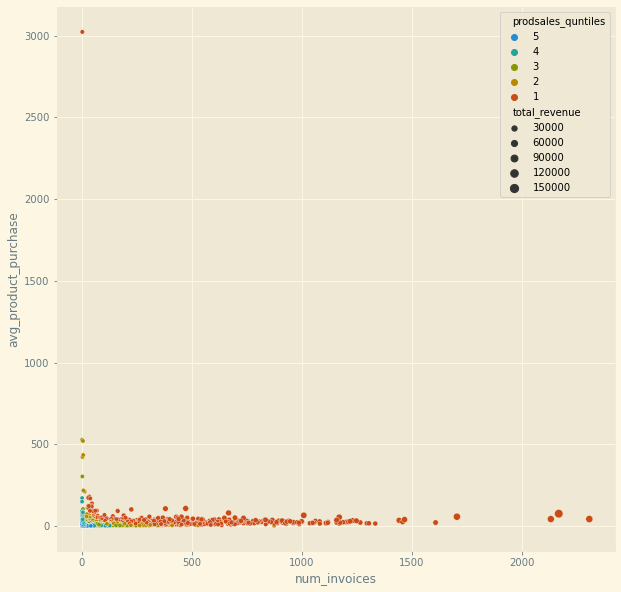

In [51]:
fig,ax = plt.subplots(figsize=(10,10))
sns.scatterplot(data=sales_by_product, 
                x='num_invoices', 
                y='avg_product_purchase', 
                size='total_revenue', 
                hue='prodsales_quntiles')

In [52]:
sales_data['has_product'] = sales_data['quantity'] > 1

In [53]:
qty_matrix = pd.pivot_table(data=sales_data, values='has_product', index='customerid', columns='stockcode_caps')

<AxesSubplot:xlabel='stockcode_caps', ylabel='customerid'>

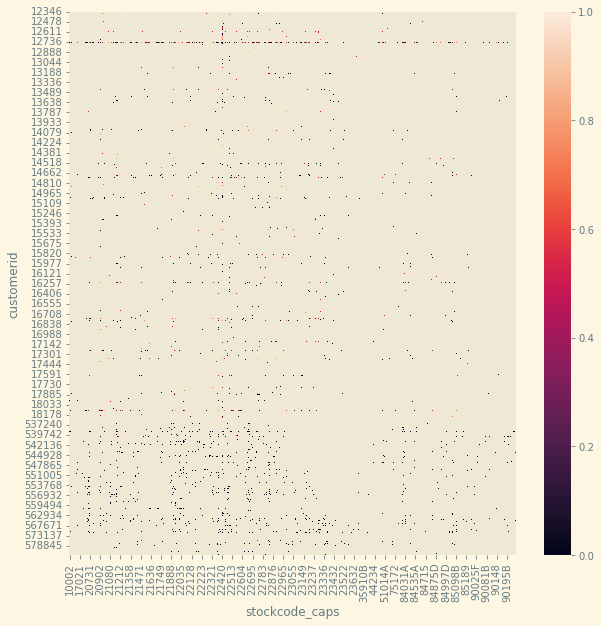

In [54]:
fig,ax = plt.subplots(figsize=(10,10))
sns.heatmap(data=qty_matrix)

Basic Model

In [55]:
# split train and test data
train_data = sales_data[sales_data['test'] == False].copy()

In [56]:
test_data = sales_data[sales_data['test'] == True].copy()

In [180]:
test_data[test_data['customerid'].apply(len)==5]['invoicedate'].describe()

C:\Users\deang\AppData\Local\Temp\ipykernel_19728\1434893423.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  test_data[test_data['customerid'].apply(len)==5]['invoicedate'].describe()


count                   93434
unique                   4193
top       2011-12-05 17:17:00
freq                      528
first     2010-12-01 09:53:00
last      2011-12-09 12:50:00
Name: invoicedate, dtype: object

In [183]:
test_data[test_data['customerid'].apply(month)]
pd.DatetimeIndex(test_data['customerid']).month

NameError: name 'month' is not defined

In [184]:
test_data[test_data['customerid'].apply(len)==5]['invoicedate'].describe()

C:\Users\deang\AppData\Local\Temp\ipykernel_19728\1434893423.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  test_data[test_data['customerid'].apply(len)==5]['invoicedate'].describe()


count                   93434
unique                   4193
top       2011-12-05 17:17:00
freq                      528
first     2010-12-01 09:53:00
last      2011-12-09 12:50:00
Name: invoicedate, dtype: object

In [57]:
pd.crosstab(index=sales_data['customerid'],
            columns=sales_data['stockcode_caps'],
            values=sales_data['revenue'], 
            aggfunc=sum,
            normalize='index'
           )

stockcode_caps  10002  10080  10120  10123C  10124A  10124G  10125  10133  \
customerid                                                                  
12346             0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0   
12347             0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0   
12348             0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0   
12349             0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0   
12350             0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0   
...               ...    ...    ...     ...     ...     ...    ...    ...   
C575153           0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0   
C577779           0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0   
C578097           0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0   
C579757           0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0   
C579907           0.0    0.0    0.0     0.0     0.0     0.0    0.0    0.0   

stockcode_caps  10135  11001  ...  DCGS0069  DCGS0070  DCGS0076  DCGSSBOY  \
customerid                    ...                                           
12346             0.0    0.0  ...       0.0       0.0       0.0       0.0   
12347             0.0    0.0  ...       0.0       0.0       0.0       0.0   
12348             0.0    0.0  ...       0.0       0.0       0.0       0.0   
12349             0.0    0.0  ...       0.0       0.0       0.0       0.0   
12350             0.0    0.0  ...       0.0       0.0       0.0       0.0   
...               ...    ...  ...       ...       ...       ...       ...   
C575153           0.0    0.0  ...       0.0       0.0       0.0       0.0   
C577779           0.0    0.0  ...       0.0       0.0       0.0       0.0   
C578097           0.0    0.0  ...       0.0       0.0       0.0       0.0   
C579757           0.0    0.0  ...       0.0       0.0       0.0       0.0   
C579907           0.0    0.0  ...       0.0       0.0       0.0       0.0   

stockcode_caps  DCGSSGIRL  GIFT_0001_10  GIFT_0001_20  GIFT_0001_30  \
customerid                                                            
12346                 0.0           0.0           0.0           0.0   
12347                 0.0           0.0           0.0           0.0   
12348                 0.0           0.0           0.0           0.0   
12349                 0.0           0.0           0.0           0.0   
12350                 0.0           0.0           0.0           0.0   
...                   ...           ...           ...           ...   
C575153               0.0           0.0           0.0           0.0   
C577779               0.0           0.0           0.0           0.0   
C578097               0.0           0.0           0.0           0.0   
C579757               0.0           0.0           0.0           0.0   
C579907               0.0           0.0           0.0           0.0   

stockcode_caps  GIFT_0001_40  GIFT_0001_50  
customerid                                  
12346                    0.0           0.0  
12347                    0.0           0.0  
12348                    0.0           0.0  
12349                    0.0           0.0  
12350                    0.0           0.0  
...                      ...           ...  
C575153                  0.0           0.0  
C577779                  0.0           0.0  
C578097                  0.0           0.0  
C579757                  0.0           0.0  
C579907                  0.0           0.0  

[5772 rows x 3817 columns]

In [59]:
test_invoices = sales_data[sales_data['test'] == True].groupby(['invoiceno',
                                                                'customerid',
                                                               'invoicedate']) \
                                                    .agg(num_products=('stockcode_caps',np.size),                                      
                                                   ).reset_index()

In [60]:
test_invoices

invoiceno customerid         invoicedate  num_products
0       536384      18074 2010-12-01 09:53:00            13
1       536393      13747 2010-12-01 10:37:00             1
2       536403      12791 2010-12-01 11:27:00             1
3       536409      17908 2010-12-01 11:45:00            58
4       536420      16583 2010-12-01 12:03:00            14
...        ...        ...                 ...           ...
5700    581582      17581 2011-12-09 12:21:00             2
5701    581584      13777 2011-12-09 12:25:00             2
5702    581585      15804 2011-12-09 12:31:00            21
5703    581586      13113 2011-12-09 12:49:00             4
5704    581587      12680 2011-12-09 12:50:00            15

[5705 rows x 4 columns]

In [66]:
test_data['cust_stock'] = test_data['customerid'] + '/' + test_data['stockcode_caps']

Recommender Models

In [68]:
test_invoices.shape[0]

5705

In [141]:
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    test_numproducts = test_invoices.loc[test_invoices['invoiceno'] == i,'num_products'].item()
    
    # sums all previous invoices of each customerid
    past_cust_invoices = train_data.loc[(train_data['customerid']==test_customerid),
                       ['customerid','stockcode_caps','revenue']] \
                        .groupby(['customerid','stockcode_caps']) \
                        .sum().reset_index()
                                         
    # compare number of products in test invoice 
    # vs unique products with positive sales in all past invoices
    past_cust_purchases = past_cust_invoices[past_cust_invoices['revenue']>0]
    past_products.extend(past_cust_purchases['stockcode_caps'])
    
    if past_cust_purchases.shape[0] > 0:
    # if there were past purchases for this customer         
        invoice_count_difference = past_cust_purchases.shape[0] - test_numproducts       
        if invoice_count_difference >= 0:                                                 
        # and if the past purchases had more products than the test invoice
        # select the top n products where n = product length of test invoice
            predict_data.extend(past_cust_purchases.head(test_numproducts).values.tolist())
        
        else:
        # else, being that the past puchases were fewer than test invoice,
        # add the products from past purchases, 
            predict_data.extend(past_cust_purchases.values.tolist())
        # and add additional products from all past invoices
        # to make up for the shortfall in products
            past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                               ['stockcode_caps','revenue']] \
                                .groupby(['stockcode_caps']) \
                                .sum().reset_index()
            past_all_invoices['customerid'] = test_customerid
            past_all_purchases = past_all_invoices[past_all_invoices['revenue']>0]      
            past_all_purchases_select = past_all_purchases[~past_all_purchases['stockcode_caps'].isin(
                past_products)]
            predict_invoice.extend(past_all_purchases_select[['customerid',
                                                              'stockcode_caps',
                                                              'revenue']] \
                                .sort_values(by='revenue',ascending=False) \
                                .head(-invoice_count_difference).values.tolist())   
    else:
    # else, being that there were no past purchases 
    # select all sales before test invoice date
        past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                           ['stockcode_caps','revenue']] \
                            .groupby(['stockcode_caps']) \
                            .sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue']] \
                            .sort_values(by='revenue',ascending=False) \
                            .head(test_numproducts).values.tolist())   
    predict_data.extend(predict_invoice)

In [145]:
predict = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])

In [147]:
predict['cust_stock'] = predict['customerid'] + '/' + predict['stockcode_caps']

In [148]:
test_data['prediction'] = test_data['cust_stock'].isin(predict['cust_stock'])

In [149]:
test_data[test_data['prediction']==True]['revenue'].sum() / test_data['revenue'].sum()

0.24969684133799824

Exponential decay function, assume effect of relevance decays uniformly over time. 

In [150]:
sales_data['invoice_age'] = pd.to_timedelta(sales_data['invoicedate'].max() 
                                            - sales_data['invoicedate']) / np.timedelta64(1, "D")

In [151]:
sales_data['invoice_age']

0         373.183333
1         373.183333
2         373.183333
3         373.183333
4         373.183333
             ...    
536488      0.023611
536489      0.023611
536490      0.023611
536491      0.023611
536492      0.023611
Name: invoice_age, Length: 536493, dtype: float64

In [152]:
age_midpoint = sales_data['invoice_age'].max()/2

In [153]:
sales_data['decay'] = np.exp(np.log(0.5) / age_midpoint * sales_data['invoice_age'])

In [154]:
sales_data['decay']

0         0.250000
1         0.250000
2         0.250000
3         0.250000
4         0.250000
            ...   
536488    0.999912
536489    0.999912
536490    0.999912
536491    0.999912
536492    0.999912
Name: decay, Length: 536493, dtype: float64

In [155]:
sales_data['revenue_decay'] = sales_data['revenue'] * sales_data['decay']

In [158]:
# Train test split
train_data = sales_data[sales_data['test'] == False].copy()
test_data = sales_data[sales_data['test'] == True].copy()

In [165]:
test_data['cust_stock'] = test_data['customerid'] + '/' + test_data['stockcode_caps']

In [159]:
# replace 'revenue' with 'revenue_decay' 
# for each invoice: 
predict_data = []
for i in test_invoices['invoiceno'].values:
    predict_invoice = []
    past_products = []
    test_customerid = test_invoices.loc[test_invoices['invoiceno'] == i,'customerid'].item()
    test_invoicedate = test_invoices.loc[test_invoices['invoiceno'] == i,'invoicedate'].item()
    test_numproducts = test_invoices.loc[test_invoices['invoiceno'] == i,'num_products'].item()
    
    # sums all previous invoices of each customerid
    past_cust_invoices = train_data.loc[(train_data['customerid']==test_customerid),
                       ['customerid','stockcode_caps','revenue_decay']] \
                        .groupby(['customerid','stockcode_caps']) \
                        .sum().reset_index()
                                         
    # compare number of products in test invoice 
    # vs unique products with positive sales in all past invoices
    past_cust_purchases = past_cust_invoices[past_cust_invoices['revenue_decay']>0]
    past_products.extend(past_cust_purchases['stockcode_caps'])
    
    if past_cust_purchases.shape[0] > 0:
    # if there were past purchases for this customer         
        invoice_count_difference = past_cust_purchases.shape[0] - test_numproducts       
        if invoice_count_difference >= 0:                                                 
        # and if the past purchases had more products than the test invoice
        # select the top n products where n = product length of test invoice
            predict_data.extend(past_cust_purchases.head(test_numproducts).values.tolist())
        
        else:
        # else, being that the past puchases were fewer than test invoice,
        # add the products from past purchases, 
            predict_data.extend(past_cust_purchases.values.tolist())
        # and add additional products from all past invoices
        # to make up for the shortfall in products
            past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                               ['stockcode_caps','revenue_decay']] \
                                .groupby(['stockcode_caps']) \
                                .sum().reset_index()
            past_all_invoices['customerid'] = test_customerid
            past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay']>0]      
            past_all_purchases_select = past_all_purchases[~past_all_purchases['stockcode_caps'].isin(
                past_products)]
            predict_invoice.extend(past_all_purchases_select[['customerid',
                                                              'stockcode_caps',
                                                              'revenue_decay']] \
                                .sort_values(by='revenue_decay',ascending=False) \
                                .head(-invoice_count_difference).values.tolist())   
    else:
    # else, being that there were no past purchases 
    # select all sales before test invoice date
        past_all_invoices = train_data.loc[(train_data['invoicedate']<test_invoicedate),
                           ['stockcode_caps','revenue_decay']] \
                            .groupby(['stockcode_caps']) \
                            .sum().reset_index()
        past_all_invoices['customerid'] = test_customerid
        past_all_purchases = past_all_invoices[past_all_invoices['revenue_decay']>0]
        predict_invoice.extend(past_all_purchases[['customerid','stockcode_caps','revenue_decay']] \
                            .sort_values(by='revenue_decay',ascending=False) \
                            .head(test_numproducts).values.tolist())   
    predict_data.extend(predict_invoice)

In [160]:
predict_decay = pd.DataFrame(predict_data, columns=['customerid','stockcode_caps','revenue'])

In [163]:
predict_decay['cust_stock'] = predict_decay['customerid'] + '/' + predict_decay['stockcode_caps']

In [166]:
test_data['prediction_decay'] = test_data['cust_stock'].isin(predict_decay['cust_stock'])

In [168]:
test_data[test_data['prediction_decay']==True]['revenue'].sum() / test_data['revenue'].sum()

0.25598539357955624

We have slight improvement

Product classification

Extract Colours
Extract Numbers


1. Generate NGrams
2. Vectorize

In [ ]:
import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
import regex as re
import webcolors

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist

In [ ]:
descriptions = revenue_codes[['description_new']].copy()

In [ ]:
color_list = list(webcolors.CSS3_NAMES_TO_HEX.keys())

In [ ]:
# Convert descriptions to lowercase
descriptions['description_lower'] = descriptions['description_new'].str.lower()

In [ ]:
descriptions

In [ ]:
type(stopwords.words('english'))

In [ ]:
def extract_non_text(string):
    extract = "".join(re.findall(r'[^a-zA-Z\s]',string))
    string = "".join(re.findall(r'[a-zA-Z\s]',string))
    return string, extract

In [ ]:
def extract_color(string_list):
    colors = []
    for i in color_list:
        if i in string_list:
            string_list.remove(i)
            colors.append(i)
    if len(colors) == 0:
        colors = np.nan
    return string_list, colors

In [ ]:
def extract_design_size(string_list):
    design_extracted = []
    size_extracted = []
    
    for i in design_list:
        if i in string_list:
            string_list.remove(i)
            design_extracted.append(i)
            
    for i in size_list:
        if i in string_list:
            string_list.remove(i)
            size_extracted.append(i)
    
    if len(design_extracted) == 0:
        design_extracted = np.nan
    if len(size_extracted) == 0:
        size_extracted = np.nan
    
    return string_list, design_extracted, size_extracted

In [ ]:
# Extract numerical and non-text characters
descriptions['clean'], descriptions['num_special_char'] = zip(*descriptions['description_lower'].
                                                              apply(extract_non_text))

In [ ]:
# Remove excess space and convert strings to lists of words
descriptions['clean'] = descriptions['clean'] \
                                            .str.strip() \
                                            .apply(lambda x: list(x.split()))

In [ ]:
# Extract colors
descriptions['clean'], descriptions['color']= zip(*descriptions['clean'].apply(extract_color))

In [ ]:
#descriptions['clean'].apply(lambda x: " ".join(x))

In [ ]:
# Combine back list of strings to one string each
X = descriptions['clean'].copy()

In [ ]:
X

In [ ]:
# Initial vectorization
cvec = CountVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x, preprocessor=lambda x: x
                      )
cvec.fit(X)
X_cvec = cvec.transform(X)

In [ ]:
X_cvec = pd.DataFrame(X_cvec.todense(),
             columns=cvec.get_feature_names_out()
            )

In [ ]:
X_cvec.sum().sort_values(ascending=False).head(50)

In [ ]:
design_list = ['heart', 'vintage','christmas', 'rose', 'polkadot', 'design', 'flower', 
               'metal','glass', 'retrospot', 'crystal', 'love', ]
size_list = ['small', 'large', 'mini', 'assorted', 'set', 'of',
             'and', 'with', 'in', 'pack', 'w', 's', 'pair', 'bag']

In [ ]:
# Extract design and size related words
descriptions['clean2'], descriptions['design'], descriptions['size'] \
    = zip(*descriptions['clean'].apply(extract_design_size))

In [ ]:
descriptions[descriptions['description_lower'].str.contains('egg')]

In [ ]:
X = descriptions['clean2'].copy()

In [ ]:
# vectorization
cvec = CountVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x, preprocessor=lambda x: x
                      )
cvec.fit(X)
X_cvec = cvec.transform(X)

X_cvec = pd.DataFrame(X_cvec.todense(),
             columns=cvec.get_feature_names_out()
            )

In [ ]:
X_cvec.sum().sort_values(ascending=False).head(50)

In [ ]:
sc_cvec = StandardScaler()
X_cvec_sc = sc_cvec.fit_transform(X_cvec)

In [ ]:
km = KMeans(n_clusters=20, random_state=42)
km.fit(X_cvec_sc)

In [ ]:
km.labels_

In [ ]:
revenue_codes['cluster_cvec_km'] = km.labels_

In [ ]:
revenue_codes['cluster_cvec_km'].value_counts()

In [ ]:
revenue_codes[revenue_codes['cluster_cvec_km']==42].sort_values(by='cluster_cvec_km')

In [ ]:
silhouette_score(X_cvec_sc, km.labels_)

In [ ]:
dbscan = DBSCAN(eps=0.1)
dbscan.fit(X_cvec_sc);

In [ ]:
silhouette_score(X_cvec_sc, dbscan.labels_)

In [ ]:
revenue_codes['cluster_cvec_dbscan'] = dbscan.labels_

In [ ]:
revenue_codes['cluster_cvec_dbscan'].value_counts()

In [ ]:
tvec = TfidfVectorizer(ngram_range=(1, 2), tokenizer=lambda x: x, preprocessor=lambda x: x
                      )
tvec.fit(X)
X_tvec = tvec.transform(X)

In [ ]:
X_tvec = pd.DataFrame(X_tvec.todense(),
             columns=tvec.get_feature_names_out()
            )

In [ ]:
X_tvec.sum().sort_values()

In [ ]:
sc_tvec = StandardScaler()
X_tvec_sc = sc_tvec.fit_transform(X_tvec)

In [ ]:
km_tvec = KMeans(n_clusters=20, random_state=42)
km_tvec.fit(X_tvec_sc)

In [ ]:
silhouette_score(X_tvec_sc, km_tvec.labels_)

In [ ]:
revenue_codes['cluster_tvec_km'] = km_tvec.labels_

In [ ]:
revenue_codes['cluster_tvec_km'].value_counts()

In [ ]:
dbscan_tvec = DBSCAN(eps=0.9)
dbscan_tvec.fit(X_tvec_sc);

In [ ]:
silhouette_score(X_tvec_sc, dbscan_tvec.labels_)

In [ ]:
revenue_codes['cluster_tvec_dbscan'] = dbscan.labels_

In [ ]:
revenue_codes['cluster_tvec_dbscan'].value_counts()

In [ ]:
X_cvec_hierarchy = X_cvec.values
z = linkage(X_cvec_hierarchy , 'single')

In [ ]:
dendrogram(z);

In [ ]:
fcluster(z,2,criterion='distance')

In [ ]:
revenue_codes['cluster_linkage'] = fcluster(z,1.2,criterion='distance')

In [ ]:
revenue_codes['cluster_linkage'].value_counts().loc[lambda x: x>1]

In [ ]:
revenue_codes[revenue_codes['cluster_linkage']==1077]

In [ ]:
silhouette_score(X_cvec_hierarchy, fcluster(z,1.2,criterion='distance'))

In [ ]:
X_tvec_hierarchy = X_tvec.values
z = linkage(X_tvec_hierarchy, 'single')

In [ ]:
dendrogram(z);

In [ ]:
revenue_codes['cluster_tvec_linkage'] = fcluster(z,0.9,criterion='distance')

In [ ]:
revenue_codes['cluster_tvec_linkage'].value_counts().loc[lambda x: x>1]

In [ ]:
silhouette_score(X_tvec_hierarchy, fcluster(z,0.9,criterion='distance'))

In [ ]:
revenue_codes[['stockcode_caps','description_new']].value_counts()

In [ ]:
revenue_codes['stockcode_caps_description'] = revenue_codes['stockcode_caps'] + revenue_codes['description_new']

In [ ]:
sales_data['stockcode_caps_description'] = sales_data['stockcode_caps'] + sales_data['description_new']

In [ ]:
sales_data = sales_data.merge(revenue_codes[['stockcode_caps_description','cluster_tvec_linkage']], 
                              how='left', 
                              on='stockcode_caps_description')

In [ ]:
sales_data.head()

In [ ]:
sales_data.pivot_table(index='customerid',columns='cluster_tvec_linkage',values='revenue', aggfunc=sum)

In [ ]:
product_by_customers = pd.crosstab(index=sales_data['customerid'],
            columns=sales_data['cluster_tvec_linkage'],
            values=sales_data['revenue'], 
            aggfunc=sum,
            normalize='index'
           )

In [ ]:
product_by_customers

In [ ]:
sc_product_by_customers = StandardScaler()
X_product_by_customers = sc_product_by_customers.fit_transform(product_by_customers.values)

In [ ]:
km_product_by_customers = KMeans(n_clusters=10, random_state=42)
km_product_by_customers.fit(X_product_by_customers)

In [ ]:
product_by_customers['cluster_cvec_km'] = km_product_by_customers.labels_

In [ ]:
product_by_customers['cluster_cvec_km'].value_counts()

In [ ]:
dbscan_product_by_customers = DBSCAN(eps=0.01)
dbscan_product_by_customers.fit(X_product_by_customers);

In [ ]:
product_by_customers['cluster_dbscan'] = dbscan_product_by_customers.labels_
product_by_customers['cluster_dbscan'].value_counts()

In [ ]:
#z = linkage(X_product_by_customers , 'single')
#dendrogram(z);

In [ ]:
#product_by_customers['cluster_linkage'] = fcluster(z, 0.9, criterion = 'distance')